# Retail Data Wrangling and Analytics

In [0]:

df = spark.table("retail_output")
df.show()

+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|invoice_no|stock_code|         description|quantity|       invoice_date|unit_price|customer_id|       country|
+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|    489434|     85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00|      6.95|      13085|United Kingdom|
|    489434|    79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|    79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|     22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|       2.1|      13085|United Kingdom|
|    489434|     21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00|      1.25|      13085|United Kingdom|
|    489434|     22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00|      1.65|      13085|United K

In [0]:
#Write your code in one or more cells (please remove this line from your notebook)

retail_df = spark.table("retail_output")
retail_df.show(10)


+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|invoice_no|stock_code|         description|quantity|       invoice_date|unit_price|customer_id|       country|
+----------+----------+--------------------+--------+-------------------+----------+-----------+--------------+
|    489434|     85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00|      6.95|      13085|United Kingdom|
|    489434|    79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|    79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00|      6.75|      13085|United Kingdom|
|    489434|     22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|       2.1|      13085|United Kingdom|
|    489434|     21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00|      1.25|      13085|United Kingdom|
|    489434|     22064|PINK DOUGHNUT TRI...|      24|2009-12-01 07:45:00|      1.65|      13085|United K

In [0]:
retail_df.printSchema()

root
 |-- invoice_no: string (nullable = true)
 |-- stock_code: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- invoice_date: timestamp (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- country: string (nullable = true)



In [0]:
description_df = retail_df.describe()
description_df.show()

+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|summary|        invoice_no|        stock_code|         description|          quantity|        unit_price|       customer_id|    country|
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|  count|           1067371|           1067371|             1062989|           1067371|           1067371|            824364|    1067371|
|   mean| 537608.1499316233|29011.161534536903|            21848.25|   9.9388984711033|  4.64938750256987| 15324.63850435002|       NULL|
| stddev|26662.450446913863| 18822.94286618906|   922.9197780233488|172.70579407675373|123.55308764985524|1697.4644503793163|       NULL|
|    min|            489434|             10002|  DOORMAT UNION J...|            -80995|          -53594.4|             12346|  Australia|
|    max|           C581569|      

# Total Invoice Amount Distribution

['Mean', 'Median', 'Mode', 'Maximum', 'Minimum']
[511.055587478452, 296.0, 15.0, 168469.0, 1.0]


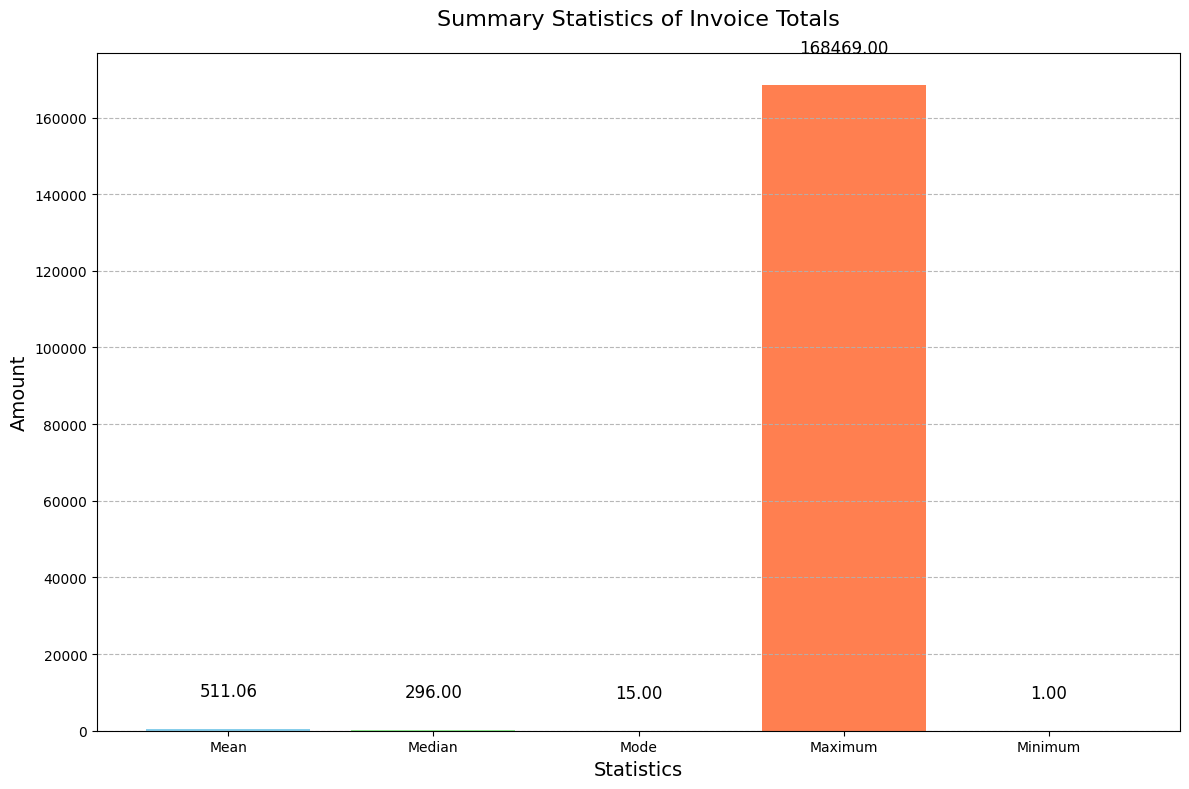

In [0]:
from pyspark.sql.functions import col, sum, expr, count, max, min
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode



invoice_df = retail_df.withColumn("invoice_amount", (col("unit_price") * col("quantity")).cast('int'))
invoice_df = invoice_df.filter(col("invoice_amount") > 0)

invoice_df = invoice_df.groupBy('invoice_no').agg(sum('invoice_amount').alias("invoice_amount"))


mean_amount = invoice_df.agg(expr("mean(invoice_amount) as mean_amount")).collect()[0][0]
median_amount = invoice_df.select(expr("percentile_approx(invoice_amount, 0.5) as median_amount")).collect()[0][0]
mode_row = invoice_df.groupBy("invoice_amount").agg(count("*").alias("count")).orderBy(col("count").desc()).limit(1).collect()
mode_amount = mode_row[0][0] if mode_row else 0  # Handle empty case

max_amount = invoice_df.agg(expr("max(invoice_amount) as max_amount")).collect()[0][0]
min_amount = invoice_df.agg(expr("min(invoice_amount) as min_amount")).collect()[0][0]


statistics = {
    'Mean': float(mean_amount),
    'Median': float(median_amount),
   'Mode': float(mode_amount),
    'Maximum': float(max_amount),
    'Minimum': float(min_amount)
}

labels = list(statistics.keys())
values = list(statistics.values())

print(labels)
print(values)

plt.figure(figsize=(12, 8))
plt.bar(labels, values, color=['skyblue', 'lightgreen', 'orange', 'coral', 'violet'])

plt.title('Summary Statistics of Invoice Totals', fontsize=16, pad=20)
plt.ylabel('Amount', fontsize=14)
plt.xlabel('Statistics', fontsize=14)

for i, value in enumerate(values):
    plt.text(i, value + 0.05 * __builtins__.max(values), f'{value:.2f}', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.9)

plt.tight_layout()
plt.show()



In [0]:
invoice_df.summary().show()

+-------+------------------+
|summary|    invoice_amount|
+-------+------------------+
|  count|           1041671|
|   mean| 20.13396564558274|
| stddev|203.11665252840518|
|    min|             0.001|
|    25%|               3.9|
|    50%|              9.96|
|    75%|17.700000000000003|
|    max|          168469.6|
+-------+------------------+



# Monthly Placed and Canceled Orders

+------+-------------+----------------+
| month|placed_orders|cancelled_orders|
+------+-------------+----------------+
|200912|        45228|            1015|
|201001|        31555|             686|
|201002|        29388|             576|
|201003|        41511|             844|
|201004|        34057|             626|
|201005|        35323|             983|
|201006|        39983|             793|
|201007|        33383|             734|
|201008|        33306|             573|
|201009|        42091|             812|
|201010|        59098|            1041|
|201011|        78015|            1194|
|201012|        65004|            1057|
|201101|        35147|             701|
|201102|        27707|             475|
|201103|        36748|             699|
|201104|        29916|             559|
|201105|        37030|             621|
|201106|        36874|             711|
|201107|        39518|             685|
+------+-------------+----------------+
only showing top 20 rows
    month  plac

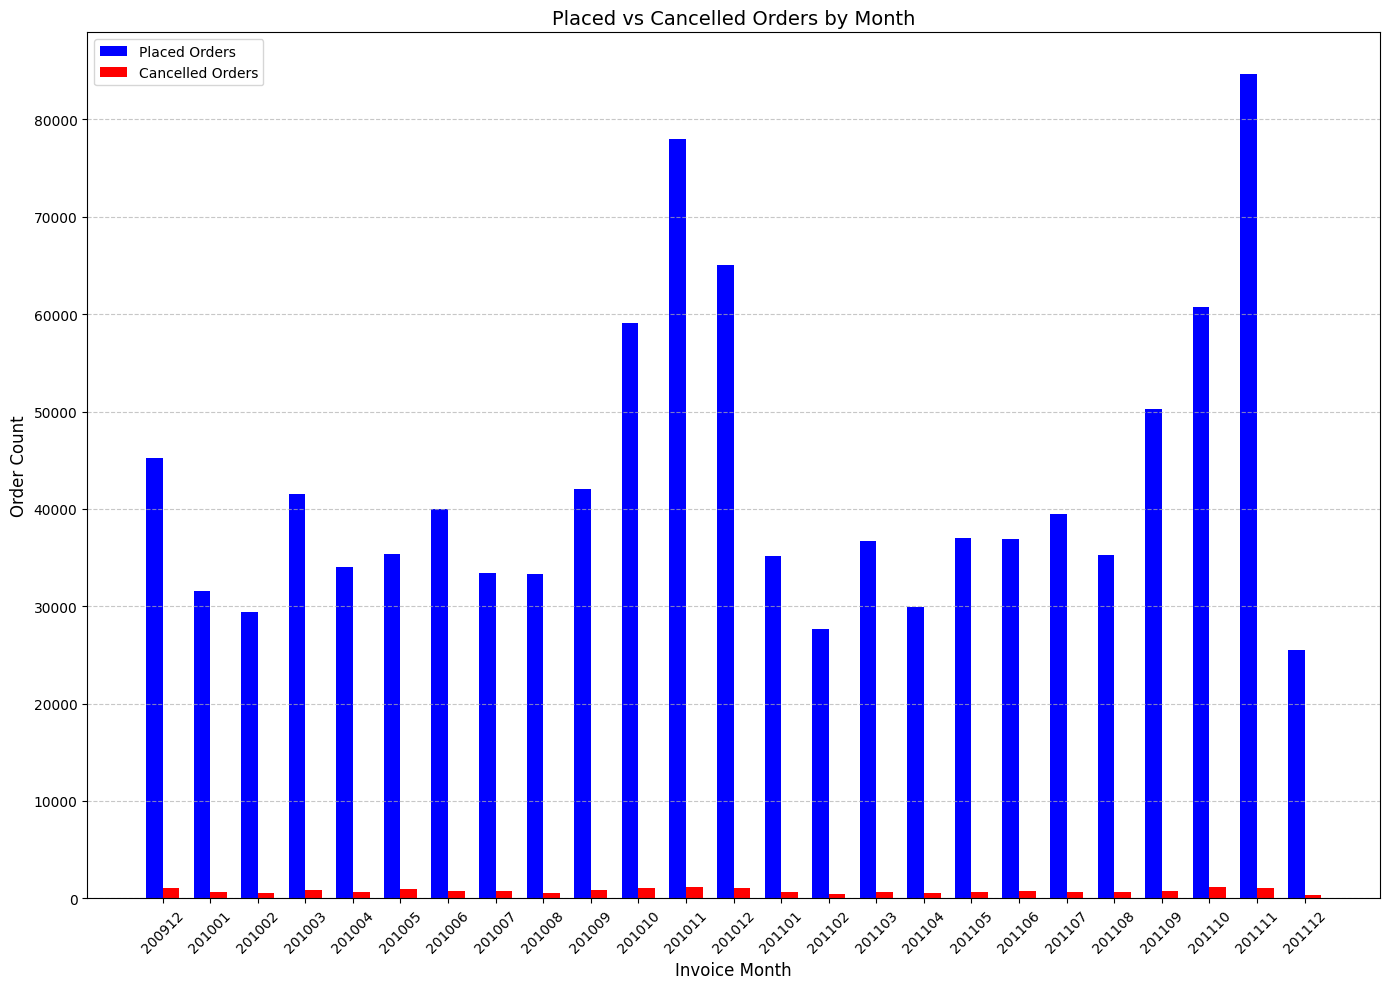

In [0]:
from pyspark.sql.functions import to_timestamp, month , year, concat, date_format
import pandas as pd

df = spark.table("retail_output")

df = df.withColumn("month", concat(year(df["invoice_date"]), date_format(df["invoice_date"], "MM")))
df = df.groupBy("month").agg(count("invoice_no").alias("placed_orders")).orderBy("month")
#df.show()

# cancelled orders
cancelled_df = spark.table("retail_output").filter(col("invoice_no").startswith("C"))
cancelled_df = cancelled_df.withColumn("month", concat(year(cancelled_df["invoice_date"]), date_format(cancelled_df["invoice_date"], "MM")))
cancelled_df = cancelled_df.groupBy("month").agg(count("invoice_no").alias("cancelled_orders")).orderBy("month")
#cancelled_df.show()

df = df.join(cancelled_df, "month", "outer")
df.show()

df = df.toPandas()


plt.figure(figsize=(14, 10))

x = df["month"]

bar_width = 0.35  # Width of the bars
indices = range(len(x))
print(df.head())

plt.bar(indices, df["placed_orders"], width=bar_width, label="Placed Orders", color="blue")
plt.bar([i + bar_width for i in indices], df["cancelled_orders"], width=bar_width, label="Cancelled Orders", color="red")

plt.xlabel("Invoice Month", fontsize=12)
plt.ylabel("Order Count", fontsize=12)
plt.title("Placed vs Cancelled Orders by Month", fontsize=14)
plt.xticks([i + bar_width / 2 for i in indices], x, fontsize=10 , rotation=45 )  # Set x-tick labels at center
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


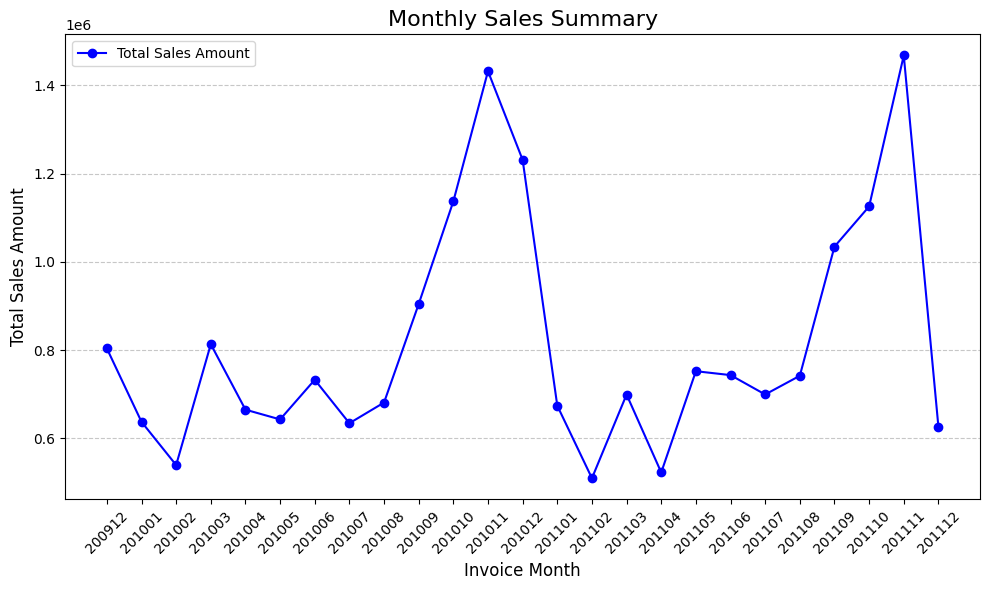

In [0]:
df = spark.table("retail_output")
df = df.withColumn("invoice_amount", (col("unit_price") * col("quantity")).cast('int'))
df = df.filter(df["invoice_amount"]>0)
df = df.withColumn("month", concat(year(df["invoice_date"]), date_format(df["invoice_date"], "MM")))
df = df.groupBy("month").agg(sum("invoice_amount").alias("total_sales")).orderBy("month")
pandas_df = df.toPandas()

plt.figure(figsize=(10, 6))

plt.plot(
    pandas_df["month"],
    pandas_df["total_sales"],
    marker="o",  # Add markers for each data point
    color="blue",
    label="Total Sales Amount"
)

plt.title("Monthly Sales Summary", fontsize=16)
plt.xlabel("Invoice Month", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()


plt.tight_layout()
plt.show()


+------+-----------+--------------+
| month|total_sales|percent_change|
+------+-----------+--------------+
|200912|     804042|          NULL|
|201001|     637685|        -20.69|
|201002|     539748|        -15.36|
|201003|     813554|         50.73|
|201004|     665270|        -18.23|
|201005|     643161|         -3.32|
|201006|     733004|         13.97|
|201007|     634523|        -13.44|
|201008|     681372|          7.38|
|201009|     904558|         32.76|
|201010|    1137212|         25.72|
|201011|    1432010|         25.92|
|201012|    1231175|        -14.02|
|201101|     674224|        -45.24|
|201102|     509981|        -24.36|
|201103|     699537|         37.17|
|201104|     523043|        -25.23|
|201105|     752390|         43.85|
|201106|     743565|         -1.17|
|201107|     699670|          -5.9|
+------+-----------+--------------+
only showing top 20 rows


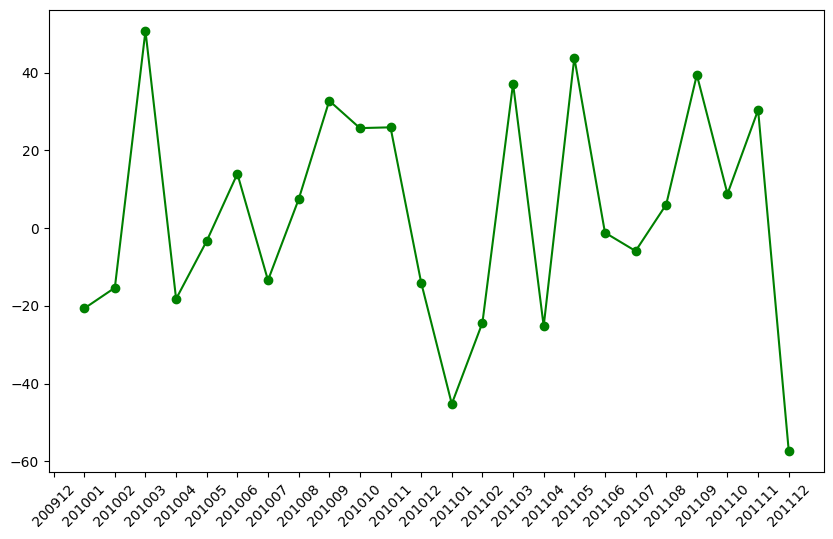

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, round
import matplotlib.pyplot as plt

df = spark.table("retail_output")
df =  retail_df.withColumn("invoice_amount", (col("unit_price") * col("quantity")).cast('int'))
df = df.filter(df["invoice_amount"]>0)
df = df.withColumn("month", concat(year(df["invoice_date"]), date_format(df["invoice_date"], "MM")))
df = df.groupBy("month").agg(sum("invoice_amount").alias("total_sales")).orderBy("month")

# used Window function to pick the previous month values so that we can calculate the growth rate
windowSpec = Window.orderBy("month")
df = df.withColumn("prev_month_sales", lag("total_sales").over(windowSpec))
df = df.withColumn("percent_change", round(((col("total_sales") - col("prev_month_sales")) / col("prev_month_sales")) * 100,2))
df = df.drop("prev_month_sales")
df.show()

df = df.toPandas()

plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
plt.plot(
    df["month"],
    df["percent_change"],
    marker="o", 
    color="green",
    label="Growth Percentage"
)


# Monthly Active Users



+------+-----+
| month|Count|
+------+-----+
|200912| 1045|
|201001|  786|
|201002|  807|
|201003| 1111|
|201004|  998|
|201005| 1062|
|201006| 1095|
|201007|  988|
|201008|  964|
|201009| 1202|
|201010| 1577|
|201011| 1683|
|201012|  948|
|201101|  783|
|201102|  798|
|201103| 1020|
|201104|  899|
|201105| 1079|
|201106| 1051|
|201107|  993|
+------+-----+
only showing top 20 rows


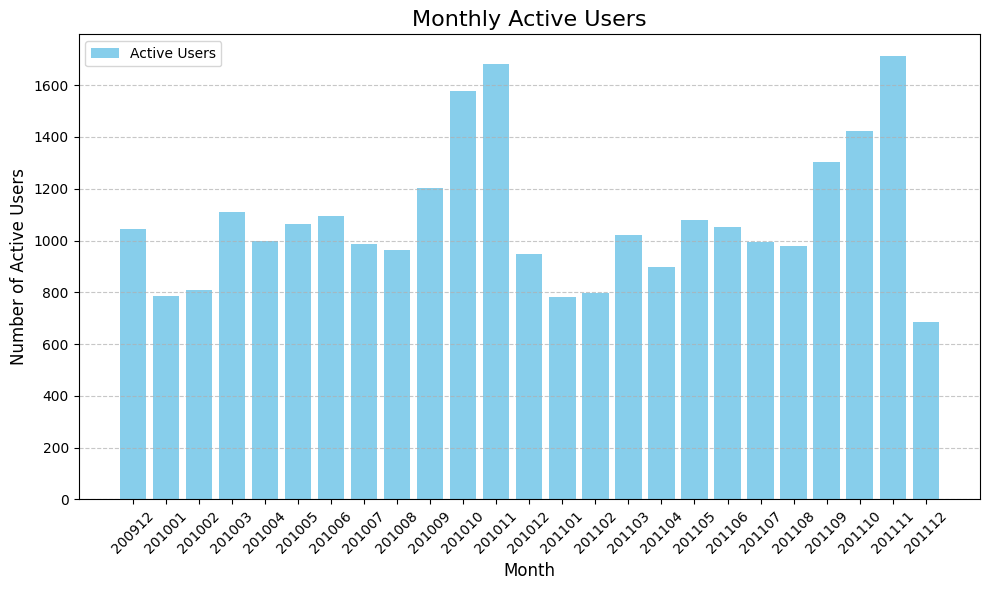

In [0]:
df = spark.table("retail_output")
df = df.withColumn("month", concat(year(df["invoice_date"]), date_format(df["invoice_date"], "MM")))
df = df.select("customer_id", "month").distinct() 
df = df.groupBy("month").agg(count("customer_id").alias("Count")).orderBy("month")
df.show()

df= df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(
    df["month"],
    df["Count"],
    color="skyblue",
    label="Active Users"
)

plt.title("Monthly Active Users", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Active Users", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize=10, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# New and Existing Users



    month  total_customer  new_customer  existing_customer
0  200912           31760          1045              30715
1  201001           22439           394              22045
2  201002           23906           363              23543
3  201003           33114           436              32678
4  201004           27833           291              27542


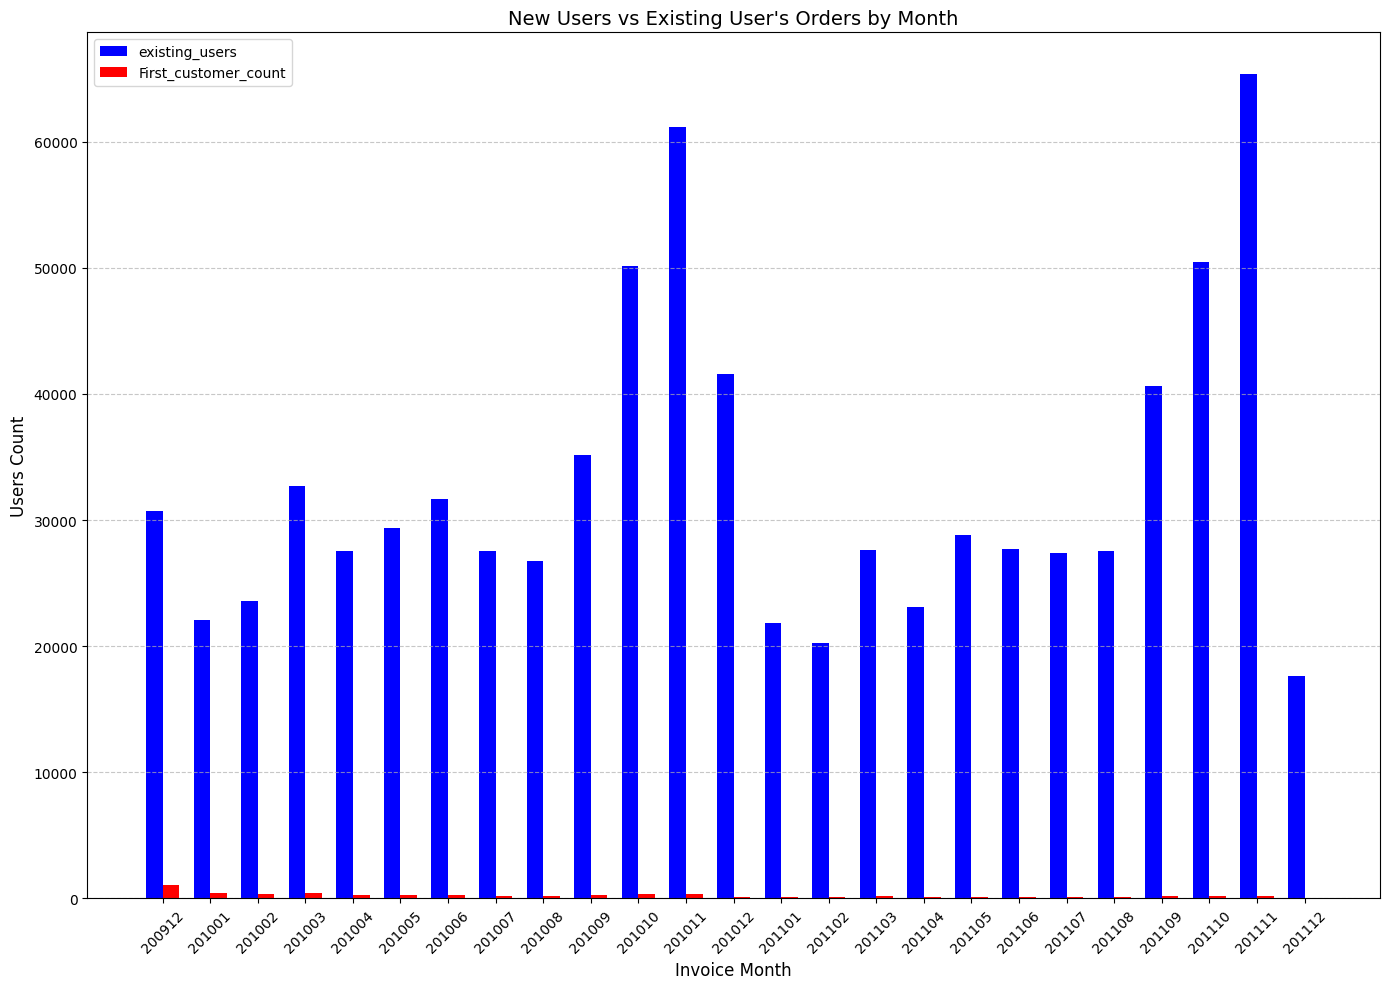

In [0]:
df = spark.table("retail_output")
df = df.withColumn("month", concat(year(df["invoice_date"]), date_format(df["invoice_date"], "MM")))
first_df = (df.groupBy("customer_id").agg(min("month").alias("month")))
first_df = first_df.groupBy("month").agg(count("customer_id").alias("new_customer")).orderBy("month")

df = (df.groupBy("month").agg(count("customer_id").alias("total_customer")))


df = df.join(first_df, "month", "outer")
df = df.withColumn("existing_customer", col("total_customer") - col("new_customer"))

df = df.toPandas()

plt.figure(figsize=(14, 10))

x = df["month"]
bar_width = 0.35  # Width of the bars
indices = range(len(x))
print(df.head())

plt.bar(indices, df["existing_customer"], width=bar_width, label="existing_users", color="blue")
plt.bar([i + bar_width for i in indices], df["new_customer"], width=bar_width, label="First_customer_count", color="red")

plt.xlabel("Invoice Month", fontsize=12)
plt.ylabel("Users Count", fontsize=12)
plt.title("New Users vs Existing User's Orders by Month", fontsize=14)
plt.xticks([i + bar_width / 2 for i in indices], x, fontsize=10 , rotation = 45)  # Set x-tick labels at center
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


2011-12-09 12:50:00


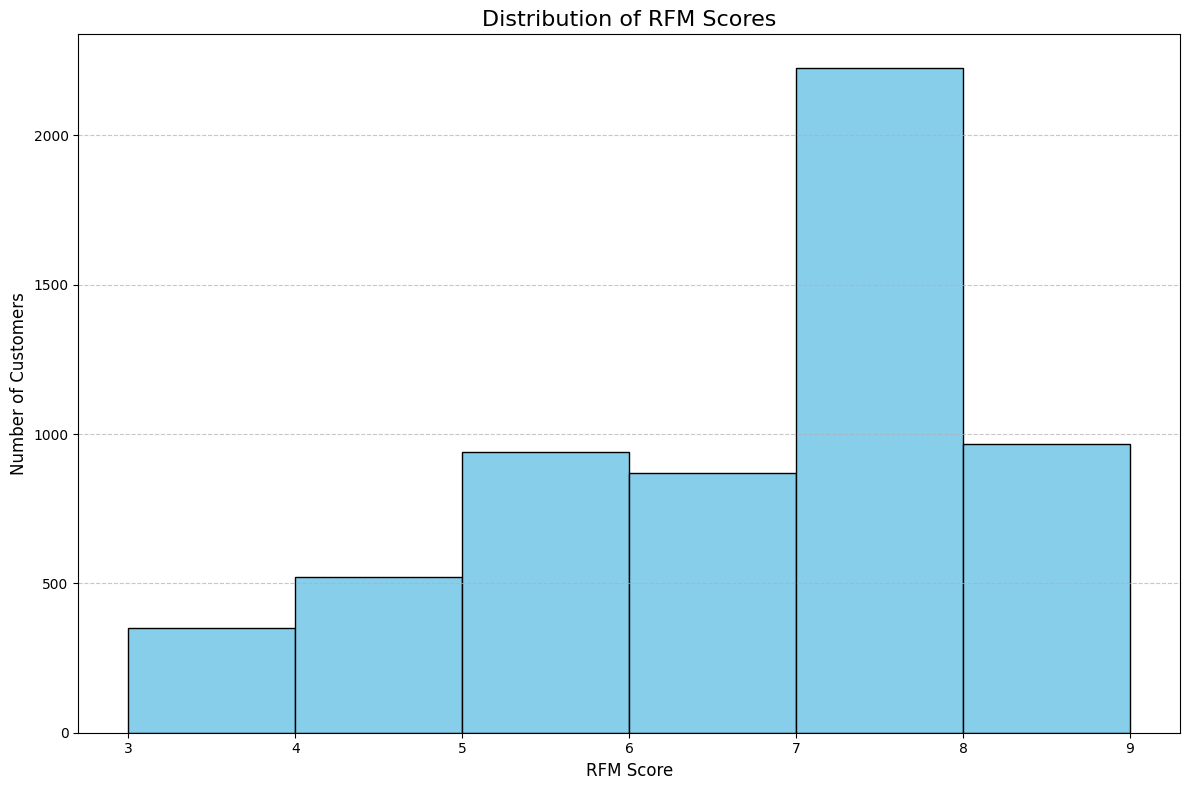

   customer_id  Recency  Frequency  Monetary  RFM_Score
0      15194.0      736        492     12233          7
1      15057.0      734         70      3230          7
2      17043.0      730        200      2519          7
3      16742.0      723        109      2801          7
4      17048.0      690        101      2024          7


In [0]:
from pyspark.sql.functions import col, max, count, sum, datediff, lit, to_date, round as spark_round
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, when, lit


df = spark.table("retail_output")
df = df.withColumn("invoice_amount", (col("unit_price") * col("quantity")).cast('int'))
df = df.filter(df["invoice_amount"]>0)
last_date = df.select(max("invoice_date")).collect()[0][0]
print(last_date)

df = df.withColumn("no_of_days_last_purchase", datediff(to_date(lit(last_date)), "invoice_date"))


rfm_df = df.groupBy("customer_id").agg(max("no_of_days_last_purchase").alias("Recency"), count("invoice_no").alias("Frequency"), sum("invoice_amount").alias("Monetary"))

quantiles = rfm_df.approxQuantile(["Recency", "Frequency", "Monetary"], [0.25, 0.5, 0.75], 0)

recency_q1, recency_q2, recency_q3 = quantiles[0]
frequency_q1, frequency_q2, frequency_q3 = quantiles[1]
monetary_q1, monetary_q2, monetary_q3 = quantiles[2]

rfm_df = rfm_df.withColumn(
    "Recency_Score",
    when(col("Recency") <= recency_q1, lit(3))
    .when(col("Recency") <= recency_q2, lit(2))
    .otherwise(lit(1))
)

rfm_df = rfm_df.withColumn(
    "Frequency_Score",
    when(col("Frequency") <= frequency_q1, lit(1))
    .when(col("Frequency") <= frequency_q2, lit(2))
    .otherwise(lit(3))
)

rfm_df = rfm_df.withColumn(
    "Monetary_Score",
    when(col("Monetary") <= monetary_q1, lit(1))
    .when(col("Monetary") <= monetary_q2, lit(2))
    .otherwise(lit(3))
)

rfm_df = rfm_df.withColumn("RFM_Score",  col("Recency_Score") + col("Frequency_Score") + col("Monetary_Score"))

rfm_df = rfm_df.withColumn('RFM_Score', col('Recency_Score') + col('Frequency_Score') + col('Monetary_Score'))
rfm_df = rfm_df.toPandas()

plt.figure(figsize=(12, 8))
plt.hist(rfm_df['RFM_Score'], bins=range(3, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of RFM Scores', fontsize=16)
plt.xlabel('RFM Score', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

print(rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']].head())


# RFM Segmentation

In [0]:
from pyspark.sql.functions import col, when, lit, concat_ws, regexp_replace, rank
from pyspark.sql.window import Window

df = spark.table("retail_output")

df = df.withColumn("invoice_amount", (col("unit_price") * col("quantity")).cast('int'))
df = df.filter(df["invoice_amount"]>0)
last_date = df.select(max("invoice_date")).collect()[0][0]
print(last_date)

df = df.withColumn("no_of_days_last_purchase", datediff(to_date(lit(last_date)), "invoice_date"))


rfm_df = df.groupBy("customer_id").agg(max("no_of_days_last_purchase").alias("Recency"), count("invoice_no").alias("Frequency"), sum("invoice_amount").alias("Monetary"))


quantiles = rfm_df.approxQuantile(["Recency", "Frequency", "Monetary"], [0.2, 0.4, 0.6, 0.8], 0)
recency_q1, recency_q2, recency_q3, recency_q4 = quantiles[0]
frequency_q1, frequency_q2, frequency_q3, frequency_q4 = quantiles[1]
monetary_q1, monetary_q2, monetary_q3, monetary_q4 = quantiles[2]

# Assign Recency Score
rfm_df = rfm_df.withColumn(
    "RecencyScore",
    when(col("Recency") <= recency_q1, lit(5))
    .when(col("Recency") <= recency_q2, lit(4))
    .when(col("Recency") <= recency_q3, lit(3))
    .when(col("Recency") <= recency_q4, lit(2))
    .otherwise(lit(1))
)

# Assign Frequency Score (Using Ranking)
rfm_df = rfm_df.withColumn(
    "FrequencyRank", rank().over(Window.orderBy("Frequency"))
)
rfm_df = rfm_df.withColumn(
    "FrequencyScore",
    when(col("FrequencyRank") <= frequency_q1, lit(1))
    .when(col("FrequencyRank") <= frequency_q2, lit(2))
    .when(col("FrequencyRank") <= frequency_q3, lit(3))
    .when(col("FrequencyRank") <= frequency_q4, lit(4))
    .otherwise(lit(5))
).drop("FrequencyRank")

# Assign Monetary Score
rfm_df = rfm_df.withColumn(
    "MonetaryScore",
    when(col("Monetary") <= monetary_q1, lit(1))
    .when(col("Monetary") <= monetary_q2, lit(2))
    .when(col("Monetary") <= monetary_q3, lit(3))
    .when(col("Monetary") <= monetary_q4, lit(4))
    .otherwise(lit(5))
)

# Create RFM Score (String Concatenation)
rfm_df = rfm_df.withColumn(
    "RFM_Score",
    concat_ws("", col("RecencyScore").cast("string"), col("FrequencyScore").cast("string"), col("MonetaryScore").cast("string"))
)

# Apply Segmentation Mapping using Regular Expressions
rfm_df = rfm_df.withColumn(
    "Segment",
    when(col("RFM_Score").rlike(r"[1-2][1-2]"), lit("Hibernating"))
    .when(col("RFM_Score").rlike(r"[1-2][3-4]"), lit("At Risk"))
    .when(col("RFM_Score").rlike(r"[1-2]5"), lit("Can't Lose"))
    .when(col("RFM_Score").rlike(r"3[1-2]"), lit("About to Sleep"))
    .when(col("RFM_Score").rlike(r"33"), lit("Need Attention"))
    .when(col("RFM_Score").rlike(r"[3-4][4-5]"), lit("Loyal Customers"))
    .when(col("RFM_Score").rlike(r"41"), lit("Promising"))
    .when(col("RFM_Score").rlike(r"51"), lit("New Customers"))
    .when(col("RFM_Score").rlike(r"[4-5][2-3]"), lit("Potential Loyalists"))
    .when(col("RFM_Score").rlike(r"5[4-5]"), lit("Champions"))
    .otherwise(lit("Other"))
)

# Show the first few rows
rfm_df.select("customer_id", "Recency", "Frequency", "Monetary", "RecencyScore", "FrequencyScore", "MonetaryScore", "RFM_Score", "Segment").show()

2011-12-09 12:50:00
+-----------+-------+---------+--------+------------+--------------+-------------+---------+-----------+
|customer_id|Recency|Frequency|Monetary|RecencyScore|FrequencyScore|MonetaryScore|RFM_Score|    Segment|
+-----------+-------+---------+--------+------------+--------------+-------------+---------+-----------+
|      15371|    662|        1|      59|           2|             1|            1|      211|Hibernating|
|      14832|    630|        1|     322|           2|             1|            2|      212|Hibernating|
|      12846|    682|        1|      15|           2|             1|            1|      211|Hibernating|
|      18233|    325|        1|     440|           4|             1|            2|      412|Hibernating|
|      17336|    472|        1|      81|           3|             1|            1|      311|Hibernating|
|      14106|    737|        1|     214|           1|             1|            1|      111|Hibernating|
|      14380|    682|        1|    